In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from numba import jit, cuda
import random

In [2]:
# importing dataset and deperating into training and testing sets

from tensorflow.keras.datasets import mnist

(training_imgs, training_labels), (testing_imgs, testing_labels)  = mnist.load_data()
training_imgs = training_imgs/255
testing_imgs = testing_imgs/255

11501568/11490434 [==============================] - 0s 0us/step


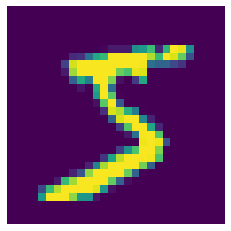

In [3]:
# Function for displaying a number
def display(img):
    plt.figure()
    plt.axis("off")
    plt.grid("off")
    plt.imshow(img)
 
item = training_imgs[0]
display(item)

In [4]:
class Variable():
  '''
  A class for Storing values and derivatives to help build up a mathmatical expression
  @x = initial value to be set to
  @weight = Determines if the variable can be updated in a machine learning system
  '''

  def __init__(self, x, weight=False):
    self.computed_value = x
    self.grad = 0
    self.weight = weight

  def set(self, x):                       # For changing the value of a variable
    self.computed_value = x

  def zero_grad(self):                    # For setting the gradient to zero
    self.grad = 0

  def optimize(self, step):               # If the variable is a weight we optimize the machine learning system using gradient descent
    if self.weight:
      self.computed_value -= step * self.grad

  def derivate(self, prop_grad=1):        # updating the gradient during derivation
    self.grad += prop_grad

  def compute(self):                      # returning the variable value
    return self.computed_value

  def __add__(self,other):                # Rules for creating expressions from variables
    return Plus(self,other)

  def __mul__(self,other):
    return Multiply(self,other)

  def __sub__(self,other):
    return Minus(self,other)


class Function():
  '''
  This class creates mathematical functions from variables connected by operators.
  It works like a tree, with operators connecting children variables.
  @args = children in the expression
  '''

  def __init__(self, *args):              # constructor - initializes the tree, value, and gradient
    self.children = args
    self.computed_value = None
    self.grad = 0

  def zero_grad(self):                    # iterate through the expression tree and zeros all gradients
    self.grad = 0
    for i in self.children:
      i.zero_grad()

  def optimize(self,step):                # iterates through tree and optimizes all ML weights in the function
    for i in self.children:
      i.optimize(step)

  def __add__(self,other):                # Rules for building larger expressions out of current expressions
    return Plus(self,other)

  def __sub__(self,other):
    return Minus(self,other)

  def __mul__(self,other):
    return Multiply(self,other)



# Function subclasses

class Plus(Function):
  def compute(self):                       # Defines rule for computing the value of an addition function
    self.computed_value = self.children[0].compute() + self.children[1].compute()
    return self.computed_value

  def derivate(self,prop_grad=1):          # Rules for taking the derivative of an addition function
    self.grad += prop_grad
    self.children[0].derivate(prop_grad)
    self.children[1].derivate(prop_grad)

class Minus(Function):                     
  def compute(self):                       
    self.computed_value = self.children[0].compute() - self.children[1].compute()
    return self.computed_value

  def derivate(self,prop_grad=1):
    self.grad += prop_grad
    self.children[0].derivate(prop_grad)
    self.children[1].derivate(-prop_grad)

class Multiply(Function):
  def compute(self):
    self.computed_value = self.children[0].compute() * self.children[1].compute()
    return self.computed_value

  def derivate(self,prop_grad=1):
    self.grad += prop_grad
    self.children[0].derivate(prop_grad*self.children[1].computed_value)
    self.children[1].derivate(prop_grad*self.children[0].computed_value)


In [5]:
class linear_network():
    '''
    This class defines a simple neural network with a simple linear layer.
    This network will output a number predicting the likleyhood the input number
    is the target number
    @taget_num = the network will check if the input is this number
    '''
    def __init__(self,target_num):
        self.target_num = target_num  
        self.truth = Variable(0)         # This is the value is used to punish or reward the model depending on if it is correct

        # model uses numpy arrays of expressions to form the layers of the neural network
        self.inputs = np.array([ [Variable(0) for i in range(28)] for j in range(28) ], dtype=object)
        self.linear_layer = np.array([ [Variable(random.uniform(.1,2),True) for i in range(28)] for j in range(28) ], dtype=object)
        self.out = self.inputs * self.linear_layer

        # The loss function is the scaled down sum of the output. self.truth makes it negative or positive depending on if the prediction was correct
        self.expression = self.truth * (self.out).sum() * Variable(.00000000001)

    def set(self,arr,label):    # iterates through the input array to set the values to the input
        for i in range(28):                   
            for k in range(28):
                self.inputs[i,k].set(arr[i,k])

        if label == self.target_num:    # The label is used for training. The reward / punishment depends on the label
            self.truth.set(-9)
        else:
            self.truth.set(1)

    def conv2d(self,arr):
        pass # To be worked on
        #out = np.empty((26,26),dtype=object)
        #for i in range(26):
        #    for k in range(26):
        #        out[i,k] = (arr[i,k] + arr[i+1,k] + arr[i+2,k] + arr[i,k+1] + arr[i+1,k+1] + arr[i+2,k+1] + arr[i,k+2] + arr[i+1,k+2] + arr[i+2,k+2]) *Variable(0.167)
        #return out


    def run(self, activation):
        self.expression.compute()   # this computes the loss - it should decrease
        activation[self.target_num] = self.expression.computed_value / self.truth.computed_value # This computes the class activation
        return self.expression.computed_value

    def derivate(self, weight=1):
        self.expression.derivate(prop_grad=weight)  # derivation function used for computing the gradient

    def optimize(self,step):
        self.expression.optimize(step)    # optimzation by using the gradient to take a step down the loss function
        self.expression.zero_grad()

    def zero_grad(self):
        self.expression.zero_grad()       # zeros the gradient in the loss function

    def predict(self,arr):                # prediction function - set the input and calculates / returns the class activation
        for i in range(28):
            for k in range(28):
                self.inputs[i,k].set(arr[i,k])
        self.expression.compute()
        return self.expression.computed_value / self.truth.computed_value
        

class num_recognition():
    '''
    The full machine learning system for number recognition
    '''
    def __init__(self):
        self.activations = [0,0,0,0,0,0,0,0,0,0]     # list for storing the class activations for each number
        self.networks = list()
        for i in range(10):
            self.networks.append(linear_network(i))  # We have a list of linear networks for each class

    def set(self,arr,label):
        for i in self.networks:                      # sets the inputs in all linear networks
            i.set(arr,label)

    def run(self):
        loss = 0
        for i in self.networks:                      # run and calculate the loss for each linear network
            loss += i.run(self.activations)
        return loss

    def derivate(self, label):
        correct_activation = self.activations[label]
        correct = 1
        for index,i in enumerate(self.networks):   # we punish all incorrect networks
            if correct_activation < self.activations[index] and index != label:
                i.derivate(weight=3) # double punishmnet if we don't have the correct answer
                correct= 0
            else:
                i.derivate()          # We reward the correct network
        return correct

    def optimize(self, step):
        for i in self.networks:
            i.optimize(step)           # optimizing the network using gradient descent on all networks

    def zero_grad(self):
        for i in self.networks:
            i.zero_grad()              # iterates through the networks zeroing all gradients

    def predict(self, arr):
        activation = list()
        for i in self.networks:                  # predicts by setting the inputs then returning the max class activation
            activation.append(i.predict(arr))
        return activation.index(max(activation))


net = num_recognition()

In [6]:
################# Finding misclassification rate ####################

def success_rate(net,testing_imgs,testing_labels):
    correct_classifications = 0
    iter = tqdm(range(testing_imgs.shape[0]))

    for i in iter:                                  # iterates through the testing images and counts the correct classifications
        prediction = net.predict(testing_imgs[i])
        if prediction == testing_labels[i]:
            correct_classifications += 1

    net.zero_grad()  # we don't derivate so this shouldn't be nessary

    print("The correct classification rate is ", (correct_classifications / testing_imgs.shape[0]) * 100)


In [7]:
################## Training Loop ########################

def train(net,training_imgs,testing_labels):
    epoch = 1
    step = 100000000
    num_imgs = 30000 
    loss = 0

    iter = tqdm(range(num_imgs))

    for k in range(epoch):       
        for i in iter:                                    # iterates through training images
            net.set(training_imgs[i],training_labels[i])  # sets the input information
            loss += net.run()                             # updates the loss
            net.derivate(training_labels[i])              # takes the derivative of the loss functions

            if i % 1000 == 999:
                net.optimize(step)                        # optimizing ever 1000 iterations (gradient is automatically zeroed by this function in the linear networks)
                loss = 0


In [8]:
print("Calculating initial correct classification rate on the testing set:")
success_rate(net,testing_imgs,testing_labels)

print("Traning model on the training set:")
train(net,training_imgs,training_labels)

print("Calculating new correct classification rate on the testing set:")
success_rate(net,testing_imgs,testing_labels)

Calculating initial correct classification rate on the testing set:


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


The correct classification rate is  9.8
Traning model on the training set:


  0%|          | 0/30000 [00:00<?, ?it/s]

Calculating new correct classification rate on the testing set:


  0%|          | 0/10000 [00:00<?, ?it/s]

The correct classification rate is  77.74


predicted: 3 correct: 3


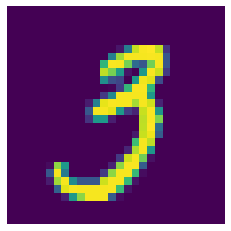

In [9]:
item = random.randrange(0,10000,1)

display(testing_imgs[item]) # printing a sample classication from the number recognition network

print("predicted:",net.predict(testing_imgs[item]), "correct:", testing_labels[item])

In [10]:
# This is the expression we will be optimize a function to fit to a set of points

# We optimze f(x) = ax^3 + bx^2 + cx + d - we optimize the coefficients abcd

x = Variable(0)       # The input into the function x
target = Variable(0)  # The expected output of the function f(x) - used for training
coefficients = [Variable(0,True) for i in range(4)] # The coeffecients a b c and d
expression = coefficients[0]*x*x*x + coefficients[1]*x*x + coefficients[2]*x + coefficients[3] # The complete function f(x) = ax^3 + bx^2 + cx + d

loss = (target - expression)*(target - expression)  # The loss function - the squared difference between the function output and the target

In [11]:
# The points for fitting the function to - This is an example and these can be altered
points = [(-8,-38.1),(-2,27.06),(1,-2.46),(3,90.16),(4,192.3),(8,1145.26),(10,2051.7)]

# function for printing the coefficitents of the function
def print_coeff(coeff):
    for i in coeff:
        print(i.computed_value,end=" ")
    print()

Initial Coeffificents:
0 0 0 0 


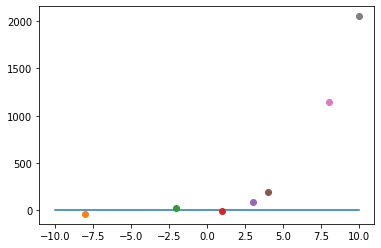

Final Coeffificents:
1.225342077588071 8.674801160825496 -4.234006522925865 -1.2381598724771439 


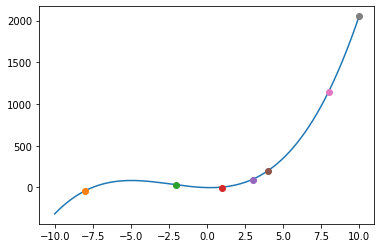

In [12]:
print("Initial Coeffificents:")
print_coeff(coefficients)

# Plotting the initial function and the points the function will be fit to
plt.figure()
x_axis = np.linspace(-10,10,1000)
y_axis = coefficients[0].computed_value*x_axis*x_axis*x_axis + coefficients[1].computed_value*x_axis*x_axis + coefficients[2].computed_value*x_axis + coefficients[3].computed_value
plt.plot(x_axis,y_axis)
for i in points:
    plt.plot(i[0],i[1],"o")
plt.show()

# Training the function
for i in range(1000000):        # experimentally chosen number of iterations
    loss.zero_grad()            # reseting the gradient for a new iteration
    for i in points:            # finding loss and derivating for each point in the set
        x.set(i[0])             
        target.set(i[1])
        loss.compute()
        loss.derivate()
    loss.optimize(.00000001)    # optimizing with an experimentally chosen step size

print("Final Coeffificents:")
print_coeff(coefficients)

# Plotting the final function and the original points
plt.figure()
x_axis = np.linspace(-10,10,1000)
y_axis = coefficients[0].computed_value*x_axis*x_axis*x_axis + coefficients[1].computed_value*x_axis*x_axis + coefficients[2].computed_value*x_axis + coefficients[3].computed_value
plt.plot(x_axis,y_axis)
for i in points:
    plt.plot(i[0],i[1],"o")
plt.show()